# Dynamic Planning  
分類 : 価値反復法
-  モデルベース  
-  価値ベース  

In [326]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

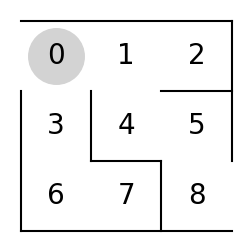

In [327]:
#迷路作成
fig = plt.figure(figsize=(3,3))

#壁
plt.plot([0, 3], [3, 3], color="k")
plt.plot([0, 3], [0, 0], color="k")
plt.plot([0, 0], [0, 2], color="k")
plt.plot([3, 3], [1, 3], color="k")
plt.plot([1, 1], [1, 2], color="k")
plt.plot([2, 3], [2, 2], color="k")
plt.plot([2, 1], [1, 1], color="k")
plt.plot([2, 2], [0, 1], color="k")

#数字
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha="center", va="center")

#円
circle, = plt.plot([0.5], [2.5], marker="o", color="#d3d3d3", markersize="40")

#メモリと枠の非表示
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="off", right="off", left="off", labelleft="off")
plt.box("off")
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)



## 環境についての情報

In [328]:
#可能な行動のリスト
possible_a = np.array([  #上、右、下、左
    [0, 1, 1, 0],      #0
    [0, 1, 1, 1],           #1
    [0, 0, 0, 1], #2
    [1, 0, 1, 0],      #3
    [1, 1, 0, 0],      #4
    [0, 0, 1, 1],      #5
    [1, 1, 0, 0],      #6
    [0, 0, 0, 1], #7
    [1, 1, 0, 0],      #8
])

#状態遷移確率
# p_t = 1

#報酬関数g
g = np.zeros((9,4))
g[8,1] = 1 

#初期状態分布 s=0から

In [329]:
def get_s_next(s, a):
    if possible_a[s,a] == 0:
        return None
    if a==0:
        return s-3
    elif a==1:
        return s+1
    elif a==2:
        return s+3
    elif a==3:
        return s-1

In [330]:
def epsilon_greedy(Q, eps=0.3):
    pi = np.zeros_like(Q)
    for s in range(Q.shape[0]):
        Q_s = [Q[s,j] if possible_a[i,j]==1 else 0 for j in range(Q.shape[1])]
        #行動が一つしかとれない場合の例外処理
        if np.count_nonzero(possible_a[s,:] == 1) == 1:
            pi[s, np.argmax(possible_a[s,:])] = 1
            continue
        #一般的な処理
        for a in range(Q.shape[1]):
            if possible_a[s,a] == 0:
                continue
            else:
                pi[s, a] = eps / np.count_nonzero(possible_a[s,:] == 1)
        pi[s, np.argmax(Q_s)] += 1 - eps  
    return pi

In [331]:
def B_pi(Q, pi, ganma=0.9):
    pi_table = pi(Q=Q)
    Q_next = Q.copy()
    for s in range(Q.shape[0]):
        for a in range(Q.shape[1]):
            if [s,a] == [8,1]:
                Q_next[s,a] = g[s,a]
            elif not get_s_next(s,a) == None:
                    Q_next[s,a] = g[s,a] + ganma *  np.sum(pi_table[get_s_next(s,a),:] * Q[get_s_next(s,a), :])
    delta = np.sum(Q_next - Q)
    return Q_next, delta

In [332]:
def B_asterisk(Q, ganma=0.9):
    Q_next = Q.copy()
    for s in range(Q.shape[0]):
        for a in range(Q.shape[1]):
            if [s,a] == [8,1]:
                Q_next[s,a] = g[s,a]
            elif not get_s_next(s,a) == None:
                Q_next[s,a] = g[s,a] + ganma * np.max(Q[get_s_next(s,a), :])
    delta = np.sum(Q_next - Q)
    return Q_next, delta

In [333]:
def learning_B_asterisk(ganma=0.9, epoch=1000, stop_epsilon=10e-3, pi=None):
    Q = np.zeros((9,4))
    delta_l = []
    for episode in range(epoch):
        Q, delta = B_asterisk(Q=Q,)
        delta_l.append(delta)
        if delta < stop_epsilon:
            break
    return Q, delta_l

def learning_B_pi(ganma=0.9, epoch=1000, stop_epsilon=10e-3, pi=None):
    Q = np.zeros((9,4))
    delta_l = []
    for episode in range(epoch):
        Q, delta = B_pi(Q=Q, pi=pi)
        delta_l.append(delta)
        if delta < stop_epsilon:
            break
    return Q, delta_l

In [334]:
#最終的な方策
def pi_d(pi):
    pi_d = np.zeros(pi.shape[0])
    for s in range(pi.shape[0]):
        pi_s = pi[s, :]
        pi_d[s] = np.argmax(pi_s)
    return pi_d

In [335]:
Q_pi, pi_delta = learning_B_pi(B_pi, pi=epsilon_greedy, stop_epsilon=10e-5)
Q_asterisk, as_delta = learning_B_asterisk(B_asterisk, stop_epsilon=10e-5)

In [336]:
pi_d1 = pi_d(Q_pi)
pi_d2 = pi_d(Q_asterisk)

print("Q_pi")
print(Q_pi)
print(pi_d1)

print()
print("Q_asterisk")
print(Q_asterisk)
print(pi_d2)

print()
print(f"answer \n[1, 2, 3, 0, 1, 2, 0, 3, 1]")

Q_pi
[[0.00000000e+00 3.78820776e-04 4.84718546e-05 0.00000000e+00]
 [0.00000000e+00 3.36415661e-04 3.42008027e-03 5.65779753e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78820776e-04]
 [5.65779753e-05 0.00000000e+00 3.84422480e-05 0.00000000e+00]
 [3.78820776e-04 2.32389685e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.52760053e-01 3.42008027e-03]
 [4.84718546e-05 3.45980232e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.84422480e-05]
 [2.32389685e-02 1.00000000e+00 0.00000000e+00 0.00000000e+00]]
[1. 2. 3. 0. 1. 2. 0. 3. 1.]

Q_asterisk
[[0.         0.6561     0.531441   0.        ]
 [0.         0.59049    0.729      0.59049   ]
 [0.         0.         0.         0.6561    ]
 [0.59049    0.         0.4782969  0.        ]
 [0.6561     0.81       0.         0.        ]
 [0.         0.         0.9        0.729     ]
 [0.531441   0.43046721 0.         0.        ]
 [0.         0.         0.         0.4782969 ]
 [0.81    

- 終了処理、一つしか行動がとれないときの例外処理を忘れていたためエラーが多かった
- epsilonが0.1だと状態７に到達しなかったが、0.3にすると７も訪問し、最適解を導けていた。
- B*の方が安定している
- B_piは収束は早いが、局所解に陥ることがある！

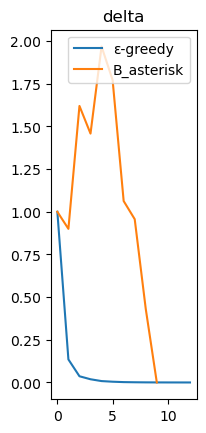

In [337]:
graph = plt.figure()


x = np.arange(len(pi_delta))
g1 = graph.add_subplot(1, 3, 1)
g1.plot(x, pi_delta, label="ε-greedy")
x = np.arange(len(as_delta))
g1.plot(x, as_delta, label="B_asterisk")
g1.set_title("delta")
g1.legend()

plt.savefig("./result/graph2.png")
plt.show()


In [338]:
""" def animate(i):
    state = s_a_history[i][0]
    circle.set_data((state % 3) + 0.5, 2.5 - int(state/3))
    return circle

anim = animation.FuncAnimation(fig, animate, frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml()) """

' def animate(i):\n    state = s_a_history[i][0]\n    circle.set_data((state % 3) + 0.5, 2.5 - int(state/3))\n    return circle\n\nanim = animation.FuncAnimation(fig, animate, frames=len(s_a_history), interval=200, repeat=False)\nHTML(anim.to_jshtml()) '